In [1]:
import os
import re
import ast
import copy
import pickle
import string
import sent2vec
import tldextract
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import preprocessor as p
from string import digits
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import remove_stopwords

tt = TweetTokenizer()


In [ ]:
## Read tweet file
df=pd.read_csv('./data/tweets.csv')

In [4]:
##Discard entries with no URLs
tmp=df[df['entities.urls'].notna()]
tmp=tmp[tmp['entities.urls']!='']
tqdm.pandas()
tmp['entities.urls']=tmp['entities.urls'].progress_apply(ast.literal_eval)

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,retweeted_user_id,quoted_user_id,created_at,...,entities.urls,entities.hashtags,lang,source,author.id,author.created_at,author.username,author.name,author.verified,bs_tag
1,1477428393775964160,1477428393775964160.0,NaN,1477376177258090496.0,NaN,1213218834322079488.0,NaN,1445729339438505984.0,NaN,2022-01-01T23:55:53.000Z,...,"[{""start"": 252, ""end"": 275, ""url"": ""https://t....",NaN,en,Twitter for Android,1213218834322079488.0,2020-01-03T22:01:40.000Z,BTristess,Bonjour 🇵🇱🇬🇧,False,0
6,1477424784862552064,1477424784862552064.0,NaN,1477376177258090496.0,NaN,1312129812396376064.0,NaN,1445729339438505984.0,NaN,2022-01-01T23:41:32.000Z,...,"[{""start"": 252, ""end"": 275, ""url"": ""https://t....",NaN,en,Twitter Web App,1312129812396376064.0,2020-10-02T20:38:35.000Z,StellaDoves,DoveStar🦕🦖 🟪⬜️🟩 No. 3640,False,0
10,1477420962802978816,1477420962802978816.0,NaN,1477134785113780224.0,NaN,1223401410.0,NaN,2854110016.0,NaN,2022-01-01T23:26:21.000Z,...,"[{""start"": 162, ""end"": 185, ""url"": ""https://t....","[{""start"": 58, ""end"": 68, ""tag"": ""RoevsWade""},...",es,Twitter Web App,1223401410.0,2013-02-27T02:10:43.000Z,aybarliliana,liliana aybar,False,0
14,1477418249247760384,1477418249247760384.0,NaN,1477376177258090496.0,NaN,1430198383348785152.0,NaN,1445729339438505984.0,NaN,2022-01-01T23:15:34.000Z,...,"[{""start"": 252, ""end"": 275, ""url"": ""https://t....",NaN,en,Twitter for Android,1430198383348785152.0,2021-08-24T16:00:58.000Z,Womanborn1,WomanbornKPSS,False,0
17,1477417641073692672,1477417641073692672.0,NaN,1477376177258090496.0,NaN,1318835413.0,NaN,1445729339438505984.0,NaN,2022-01-01T23:13:09.000Z,...,"[{""start"": 252, ""end"": 275, ""url"": ""https://t....",NaN,en,Twitter Web App,1318835413.0,2013-03-31T17:49:11.000Z,1066cariad,Cariad2 KPSS 🏴󠁧󠁢󠁷󠁬󠁳󠁿 🇪🇺 💚🤍💜😷🕷️🦖🧙‍♀,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88211204,1608976583406268417,1608976583406268417,NaN,1608926016608534528.0,NaN,557432619,NaN,20280088.0,NaN,2022-12-31T00:01:25.000Z,...,"[{""start"": 281, ""end"": 304, ""url"": ""https://t....",NaN,en,NaN,557432619,2012-04-19T02:16:55.000Z,melodyisdestiny,Allison 🌻,False,0
88211209,1608976484076773386,1608976484076773386,NaN,1608145760280780800.0,NaN,275174862,NaN,1349149096909668352.0,NaN,2022-12-31T00:01:01.000Z,...,"[{""start"": 134, ""end"": 157, ""url"": ""https://t....",NaN,en,NaN,275174862,2011-03-31T19:36:23.000Z,KataClysmic_1,Katia 🏹🎧💻📱🏳️‍🌈🎞⚖️😷📕,False,0
88211211,1608976412341604353,1608976412341604353,NaN,1608145760280780800.0,NaN,1309511815265685509,NaN,1349149096909668352.0,NaN,2022-12-31T00:00:44.000Z,...,"[{""start"": 134, ""end"": 157, ""url"": ""https://t....",NaN,en,NaN,1309511815265685509,2020-09-25T15:15:46.000Z,Silver_1_Spirit,McConnell’s empty balls sack.,False,0
88211213,1608976370348208129,1608976370348208129,NaN,1608145760280780800.0,NaN,4274450534,NaN,1349149096909668352.0,NaN,2022-12-31T00:00:34.000Z,...,"[{""start"": 134, ""end"": 157, ""url"": ""https://t....",NaN,en,NaN,4274450534,2015-11-18T03:16:27.000Z,ItsaLearning,Gia Monroe🌻,False,0


In [7]:
##Extract expanded URL from tweets.
def get_url(li):
    try:
        return [x['expanded_url'] for x in li]
    except Exception as e:
        return None
tmp['urls']=tmp['entities.urls'].progress_apply(get_url)
tmp=tmp[['author.username','urls']]
tmp=tmp.dropna()

In [10]:
## Group all URLs from user
user_dict={}
for i in tqdm(range(len(tmp))):
    user=tmp['author.username'].iloc[i]
    urls=tmp['urls'].iloc[i]
    if user not in user_dict:
        user_dict[user]=[]
    user_dict[user].extend(urls)

100%|██████████| 22855933/22855933 [09:46<00:00, 38947.22it/s]


In [11]:
user_df=pd.DataFrame(user_dict.items(),columns=['screen_name','urls'])

## Political Score

In [3]:
leftdf=pd.read_csv('/data/MBFC/left.csv')
lcdf=pd.read_csv('/data/MBFC/Left-Center.csv')
centdf=pd.read_csv('/data/MBFC/Least%20Biased.csv')
rcdf=pd.read_csv('/data/MBFC/Right-Center.csv')
rightdf=pd.read_csv('/data/MBFC/right.csv')
scidf=pd.read_csv('/data/MBFC/pro-science.csv')
antiscidf=pd.read_csv('/data/MBFC/conspiracy-pseudoscience.csv')
qdf=pd.read_csv('/data/MBFC/Questionable%20Sources.csv')

In [4]:
leftdf=leftdf[leftdf['domain'].notna()]
lcdf=lcdf[lcdf['domain'].notna()]
centdf=centdf[centdf['domain'].notna()]
rcdf=rcdf[rcdf['domain'].notna()]
rightdf=rightdf[rightdf['domain'].notna()]
scidf=scidf[scidf['domain'].notna()]
antiscidf=antiscidf[antiscidf['domain'].notna()]
qdf=qdf[qdf['domain'].notna()]

In [5]:
for i in tqdm(range(len(leftdf['domain']))):
    if 'https://' in leftdf['domain'].iloc[i]:
        uri = tldextract.extract(leftdf['domain'].iloc[i].replace('https://',''))
    else:
        uri = tldextract.extract(leftdf['domain'].iloc[i].replace('http://',''))
    leftdf['domain'].iloc[i]='.'.join(uri[1:3])

for i in tqdm(range(len(lcdf['domain']))):
    if 'https://' in lcdf['domain'].iloc[i]:
        uri = tldextract.extract(lcdf['domain'].iloc[i].replace('https://',''))
    else:
        uri = tldextract.extract(lcdf['domain'].iloc[i].replace('http://',''))
    lcdf['domain'].iloc[i]='.'.join(uri[1:3])
    
for i in tqdm(range(len(centdf['domain']))):
    if 'https://' in centdf['domain'].iloc[i]:
        uri = tldextract.extract(centdf['domain'].iloc[i].replace('https://',''))
    else:
        uri = tldextract.extract(centdf['domain'].iloc[i].replace('http://',''))
    centdf['domain'].iloc[i]='.'.join(uri[1:3])

for i in tqdm(range(len(rcdf['domain']))):
    if 'https://' in rcdf['domain'].iloc[i]:
        uri = tldextract.extract(rcdf['domain'].iloc[i].replace('https://',''))
    else:
        uri = tldextract.extract(rcdf['domain'].iloc[i].replace('http://',''))
    rcdf['domain'].iloc[i]='.'.join(uri[1:3])

for i in tqdm(range(len(rightdf['domain']))):
    if 'https://' in rightdf['domain'].iloc[i]:
        uri = tldextract.extract(rightdf['domain'].iloc[i].replace('https://',''))
    else:
        uri = tldextract.extract(rightdf['domain'].iloc[i].replace('http://',''))
    rightdf['domain'].iloc[i]='.'.join(uri[1:3])

for i in tqdm(range(len(scidf['domain']))):
    if 'https://' in scidf['domain'].iloc[i]:
        uri = tldextract.extract(scidf['domain'].iloc[i].replace('https://',''))
    else:
        uri = tldextract.extract(scidf['domain'].iloc[i].replace('http://',''))
    scidf['domain'].iloc[i]='.'.join(uri[1:3])
for i in tqdm(range(len(antiscidf['domain']))):
    if 'https://' in antiscidf['domain'].iloc[i]:
        uri = tldextract.extract(antiscidf['domain'].iloc[i].replace('https://',''))
    else:
        uri = tldextract.extract(antiscidf['domain'].iloc[i].replace('http://',''))
    antiscidf['domain'].iloc[i]='.'.join(uri[1:3])
for i in tqdm(range(len(qdf['domain']))):
    if 'https://' in qdf['domain'].iloc[i]:
        uri = tldextract.extract(qdf['domain'].iloc[i].replace('https://',''))
    else:
        uri = tldextract.extract(qdf['domain'].iloc[i].replace('http://',''))
    qdf['domain'].iloc[i]='.'.join(uri[1:3])

100%|██████████| 965/965 [00:00<00:00, 5900.38it/s]


In [18]:
poldf=leftdf.append([lcdf,centdf,rcdf,rightdf])
poldf=poldf[['domain','polarity']]

<ipython-input-18-04ae6ef0dd0a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poldf=leftdf.append([lcdf,centdf,rcdf,rightdf])


In [21]:
poldic={'Left':0,'Left-Center':0.25,'Least Biased':0.5,'Right-Center':0.75,'Right':1}
poldf['pol_score']=poldf['polarity'].map(poldic)

In [22]:
for i in range(len(poldf)):
    poldf['domain'].iloc[i]=poldf['domain'].iloc[i].strip()

<ipython-input-22-6a87b067652b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poldf['domain'].iloc[i]=poldf['domain'].iloc[i].strip()


In [23]:
def foo(url):
    return '.'.join(tldextract.extract(url)[1:3])

def clean(links):
    links = [foo(x) for x in links]
    links = [x for x in links if x in valid_domains]
    return links

In [24]:
valid_domains=poldf['domain'].tolist()
valid_domains=list(set(valid_domains))

In [25]:
user_df['len']=user_df['urls'].apply(len)
user_df=user_df[user_df['len']>2]
user_df

,screen_name,urls,len
0,BTristess,"[https://www.womensrights.network, https://twi...",84
1,StellaDoves,"[https://www.womensrights.network, https://bpa...",71
3,Womanborn1,"[https://www.womensrights.network, https://twi...",52
4,1066cariad,"[https://www.womensrights.network, https://www...",61
5,CTKelly6,"[https://www.womensrights.network, https://www...",276
...,...,...,...
4249075,mosfix100,[https://twitter.com/jamfix100/status/16084414...,4
4249088,P_Fxxx387,[https://twitter.com/Aletta_Lover88/status/160...,4
4249089,143_innaiu,[https://twitter.com/i/web/status/160812865970...,3
4249101,tomhollandly,[https://twitter.com/dannysuIIivan/status/1609...,3


In [26]:
tqdm.pandas()
user_df['cleaned_links']=user_df['urls'].progress_apply(clean)

100%|██████████| 1534697/1534697 [16:21<00:00, 1563.68it/s]


In [27]:
user_df['len']=user_df['cleaned_links'].apply(len)
user_df=user_df[user_df['len']>2]

In [28]:
poldict=dict(poldf[['domain','pol_score']].values)

In [29]:
def mapper(li):
    return np.mean([poldict[x] for x in li if x in poldict])        

In [30]:
user_df['political_gen']=user_df['cleaned_links'].progress_apply(mapper)

100%|██████████| 260506/260506 [00:06<00:00, 41643.39it/s]
<ipython-input-30-d3b1c9816e5c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df['political_gen']=user_df['cleaned_links'].progress_apply(mapper)


/nas/home/ashreyas/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


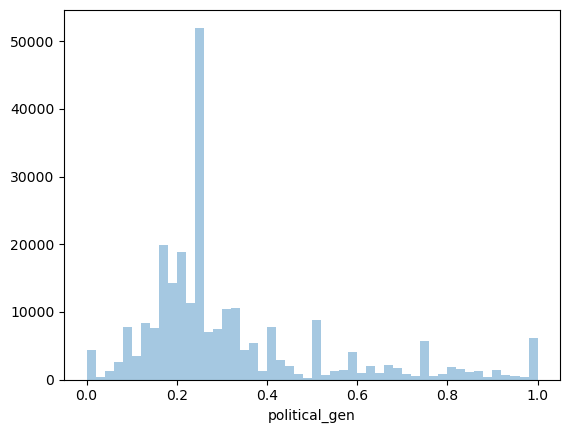

In [31]:
sns.distplot(user_df['political_gen'],kde=False)
plt.show()

In [44]:
lib=user_df[user_df['political_gen']<0.4]
cons=user_df[user_df['political_gen']>0.6]
user_df.to_csv('/data/RoeVWade/political_scores.csv',index=False)

## Merge user text

In [10]:
df=df[['author.username','text']]

In [13]:
user_text={}
for i in tqdm(range(len(df))):
    user=df['author.username'].iloc[i]
    text=df['text'].iloc[i]
    if user not in user_text:
        user_text[user]=' '
    user_text[user]=user_text[user]+' '+text

100%|██████████| 23227634/23227634 [38:02<00:00, 10177.27it/s]


In [7]:
user_text_df=pd.DataFrame(user_text.items(),columns=['screen_name','text'])

,screen_name,text
0,MikeNorthrop5,👩🏻‍♀‍👱🏻‍♀️‍♀‍👩🏻‍🦰 #WomensRights #AbortionRi...
1,driftlessarearv,👩🏻‍♀‍👱🏻‍♀️‍♀‍👩🏻‍🦰 #WomensRights #AbortionRi...
2,TeriMcGill,👩🏻‍♀‍👱🏻‍♀️‍♀‍👩🏻‍🦰 #WomensRights #AbortionRi...
3,claudiapoindex2,@BugdenSteven @kmhawknz @RonFilipkowski #myb...
4,brandon_akai,Poland's #abortion ban has cost a woman's li...
...,...,...
1671213,FlowCoachSJ,"@xlr8harder In my adult life, I choose not t..."
1671214,wallacespeaks_,Do not not use a permanent solution on a tem...
1671215,Bobos_or_Mike,"Life is choices you choose what you get, you..."
1671216,__sugarmomma11,choose your daniel padilla fur dad mode 😮‍💨🫶...


In [8]:
irrelevant_chars="~?!./\:;+=&^%$#@(,)[]_*"
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def deep_clean(x):
    x=x.lower()
    x=re.sub(r'http\S+', '', x)
    remove_digits = str.maketrans(' ', ' ', digits)
    remove_chars = str.maketrans(' ', ' ', irrelevant_chars)
    x = x.translate(remove_digits)
    x = x.translate(remove_chars)
    x = emoji_pattern.sub(r'', x)
    x=x.replace("-",' ')
    x=x.replace('!',' ')
    x=x.replace('?',' ')
    x=x.replace('@',' ')
    x=x.replace('&',' ')
    x=x.replace('$',' ')
    x=x.replace('``',' ')
    x=x.replace("'s",' ')
    x=x.replace("''",' ')
    return x


In [10]:
tqdm.pandas()
user_text_df['cleaned_text']=user_text_df['text'].progress_apply(deep_clean)

100%|██████████| 1671218/1671218 [16:32<00:00, 1683.53it/s] 


In [12]:
model = sent2vec.Sent2vecModel()
model.load_model('./models/twitter_bigrams.bin')

In [13]:
embeddings = model.embed_sentences(user_text_df['cleaned_text'].tolist())
e=embeddings.tolist()
user_text_df['embeddings']=e

In [ ]:
res=user_df.merge(user_text_df,on='screen_name')

In [24]:
hard_politics=[]
for i in tqdm(range(len(res))):
    if res['political_gen'].iloc[i]<=0.4:
        hard_politics.append(0)
    elif res['political_gen'].iloc[i]>=0.6:
        hard_politics.append(1.0)
    else:
        hard_politics.append(-100)
res['politics']=hard_politics

100%|██████████| 98100/98100 [00:01<00:00, 66750.99it/s]


In [25]:
tmp= res[res['politics']!=-100]
X_new=tmp['embeddings']
Y_new=tmp['politics']

X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new,test_size=0.33,random_state=23)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=23,max_iter=700).fit(np.asarray(X_train.tolist()), y_train.tolist())
y_pred=clf.predict(np.asarray(X_test.tolist()))
y_pred_proba = clf.predict_proba(np.asarray(X_test.tolist()))
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
print(accuracy_score(np.asarray(y_test.tolist()),y_pred))
print(precision_score(np.asarray(y_test.tolist()),y_pred,average='macro'))
print(recall_score(np.asarray(y_test.tolist()),y_pred,average='macro'))
print(f1_score(np.asarray(y_test.tolist()),y_pred,åaverage='macro'))

0.958560411311054
0.9026508861935147
0.8788024375997773
0.8902370548141805


In [27]:
cons_prob_text_df=copy.deepcopy(user_text_df)

In [29]:
all_X = embeddings
all_Y_pred_proba = clf.predict_proba(all_X)
cons_prob_text_df['pol_proba']=list(all_Y_pred_proba[:,1])
cons_prob_text_df

,screen_name,cleaned_text,embeddings,pol_proba
0,MikeNorthrop5,‍♀‍‍♀️‍♀‍‍🦰 womensrights abortionrights fre...,"[-0.1160459965467453, 0.06369031965732574, -0....",0.009328
1,driftlessarearv,‍♀‍‍♀️‍♀‍‍🦰 womensrights abortionrights fre...,"[-0.15199127793312073, 0.03899204730987549, -0...",0.006914
2,TeriMcGill,‍♀‍‍♀️‍♀‍‍🦰 womensrights abortionrights fre...,"[-0.10151023417711258, 0.10140517354011536, 0....",0.000001
3,claudiapoindex2,bugdensteven kmhawknz ronfilipkowski mybodym...,"[-0.10708104819059372, 0.05692688748240471, -0...",0.005851
4,brandon_akai,poland abortion ban has cost a woman life ...,"[-0.18553005158901215, 0.027276145294308662, -...",0.008926
...,...,...,...,...
1671213,FlowCoachSJ,xlrharder in my adult life i choose not to s...,"[-0.04543077200651169, 0.15291179716587067, -0...",0.363282
1671214,wallacespeaks_,do not not use a permanent solution on a tem...,"[-0.13210541009902954, 0.11318407207727432, -0...",0.949691
1671215,Bobos_or_Mike,life is choices you choose what you get you ...,"[-0.07120540738105774, -0.10782971978187561, 0...",0.787150
1671216,__sugarmomma11,choose your daniel padilla fur dad mode ‍🫶nn...,"[0.3627081513404846, 0.046120524406433105, 0.2...",0.503043


In [114]:
cons_prob_text_df[['screen_name','pol_proba']].to_csv('./data/user_scores_all.csv',index=False)